<a href="https://colab.research.google.com/github/cbsebastian24/randomStuff/blob/main/Copy_of_Breakout_4b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### By the end of this lab, you will be able to…
- Compute and interpret the **Pearson correlation** $r$.
- Conduct a **hypothesis test** for $H_0: r = 0$ using the **z-test** with a simple standard error approximation.
- Build a **95% confidence interval** for $r$ using a simple standard error approximation, and interpret it in context.
- Fit a **simple linear regression** $Y = \beta_0 + \beta_1 X + \varepsilon$, test $H_0: \beta_1 = 0$, and build a **95% CI** for $\beta_1$.
- Explain and **verify numerically** that the correlation test and the slope test are **the same** (with df = $n-2$).




## NHANES
The National Health and Nutrition Examination Survey (NHANES) is a
cross sectional observational study run every 2-3 years by the
United States Centers for Disease Control (CDC).  It collects
extensive demographic and health-related data on a representative
sample of the US population. We will work with a subset of the possible measures that the NHANES survey collects on basic biometric features.

To get introduced to NHANES, watch this video as a class (it's getting a little old, but still a good picture of the survey):

[NHANES Introduction Video](https://youtu.be/MGuojJXWBzA?si=JUBG2epFvVO35O5w)


First we import the libraries that we will be using.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

Now we load the NHANES data from a file.

In [2]:
# Load the data
df = pd.read_csv("https://github.com/UM-Data-Science-101/lab-07/raw/refs/heads/main/nhanes.csv.gz")

# Subset the data to include only adults
df = df.loc[df["RIDAGEYR"] >= 18]

# Redefine RIAGENDR to be categorical
df["RIAGENDR"] = df["RIAGENDR"].replace([1.0, 2.0], ["Male","Female"]).astype("category")

## Getting to know the data

The complete NHANES data set measures hundreds of different health indicators. For this lab, we use only a subset.


How many observations do we have? What are the features?

In [3]:
# WRITE YOUR CODE HERE
print(df.shape)
print(df.columns)

(5735, 9)
Index(['SEQN', 'RIDAGEYR', 'RIAGENDR', 'BMXWT', 'BMXHT', 'BMXBMI', 'BPXSY1',
       'BPXSY2', 'BPXSY3'],
      dtype='object')


<details>

```
print(df.shape)

print(df.columns) # or print(df.head())
```

</details>

Here is a brief codebook:

* SEQN: A unique number given to each participant
* RIDAGEYR: The participant's age in years
* RIAGENDR: The participant's gender
* BMXWT: The participant's weight in kilograms
* BMXHT: The participant's height in centimeters
* BMXBMI: The participant's calculated body-mass-index
* BPXSY[1,2,3]: Three systolic blood pressure measurements for the subject

With the exception of SEQN and RIAGENDR, the other variables in this data set are quantitative in nature. Use the the `.describe` method for DataFrames to learn about typical values for these measures.

In [4]:
# WRITE YOUR CODE HERE
df.describe()

,SEQN,RIDAGEYR,BMXWT,BMXHT,BMXBMI,BPXSY1,BPXSY2,BPXSY3
count,5735.000000,5735.000000,5666.000000,5673.000000,5662.000000,5401.000000,5535.000000,5505.000000
mean,88678.583435,48.052310,81.342676,166.142834,29.382197,125.084614,124.783017,124.342234
std,2882.139237,18.431011,21.764409,10.079264,7.095921,18.480873,18.527012,18.133525
min,83732.000000,18.000000,32.400000,129.700000,14.500000,82.000000,84.000000,76.000000
25%,86164.000000,32.000000,65.900000,158.700000,24.300000,112.000000,112.000000,112.000000
50%,88668.000000,48.000000,78.200000,166.000000,28.300000,122.000000,122.000000,122.000000
75%,91178.500000,63.000000,92.700000,173.500000,33.000000,134.000000,134.000000,134.000000
max,93702.000000,80.000000,198.900000,202.700000,67.300000,236.000000,238.000000,226.000000


<details>

```
df.describe()
```

</details>

# Correlation analyses of body size
The **Pearson correlation** coefficient describes the association between
two quantitative variables.  It mainly captures **linear association**,
but can detect certain types of non-linear association as well.  The
Pearson correlation coefficient is a numerical statistic that is
closely related to the relationship shown in a scatterplot.

First, we will study the relationships between weight and height.
Begin by creating a scatter plot of the height(`"BMXHT"`) and weight (`"BMXWT"`) measurements. Use `alpha = 0.4` to help deal with some of the overplotting. Think before you plot: What do you expect the correlation to be?
Positive, negative, or near zero?

This should likely be positive and linear since beig taller likely means you weigh more.

<Axes: xlabel='BMXHT', ylabel='BMXWT'>

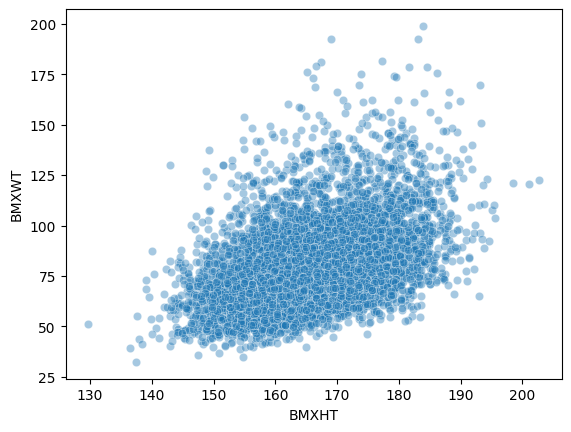

In [5]:
# WRITE YOUR CODE HERE
sb.scatterplot(data = df, x = "BMXHT", y = "BMXWT", alpha = 0.4)

<details>

```
sb.scatterplot(data = df, x = "BMXHT", y = "BMXWT", alpha = 0.4)
```

</details>

An increasing relationship (positive association) is one in which large values of X are paired with large values of Y and smalll values of X are paried with small values of Y.

To compare variables on a common scale, we standardize each measurement into a Z-score:

$$Z_i = \frac{X_i - \bar X}{S_X}$$

where $S_X$ is the standard deviation of the $X$ values.



Write a function that converts a series to its Z-score version. Call it `zscores` (we will refer to it later).

In [6]:
# WRITE YOUR CODE HERE
def zscores(s):
    return((s - s.mean()) / s.std())

<details>

```
def zscores(s):
    return((s - s.mean()) / s.std())
```

</details>

Create new columns that are the Z-scores for height and weight.

In [7]:
# WRITE YOUR CODE HERE
df["BMXHT_Z"] = zscores(df["BMXHT"])
df["BMXWT_Z"] = zscores(df["BMXWT"])

<details>
    
```
df["BMXHT_Z"] = zscores(df["BMXHT"])
df["BMXWT_Z"] = zscores(df["BMXWT"])
```

</details>

Plot the z-scores against each other and add horizontal and vertical bars using `plt.axvline(0)` and `plt.axhline(0)` to help visualize the quadrants.

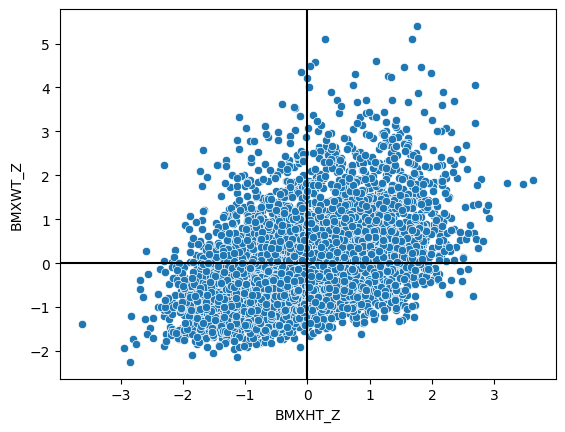

In [9]:
# WRITE YOUR CODE HERE
sb.scatterplot(data = df, x = "BMXHT_Z", y = "BMXWT_Z")
plt.axvline(0, color = "black")
plt.axhline(0, color = "black")

<details>


```
sb.scatterplot(data = df, x = "BMXHT_Z", y = "BMXWT_Z")
plt.axvline(0, color = "black")
plt.axhline(0, color = "black")
```

</details>

In which quadrants do most of these points fall? Recall that if most points fall in the upper right and lower left quadrants, we have a positive/increasing relationship. If we see most in the upper left and lower right, we have a decreasing relationshp. And if all points are equally spread out in all quadrants, we would say that there is no relationship at all.

Most of the points seem to fall in the upper right quadrant followed bt the lower left quadrant meaning we have a positive increasing realtionship.

Recall that the correlation of two variables is defined as the average product of Z-scores for the two measures:

$$r_{xy} = \frac{1}{n} \sum_{i=1}^n \frac{X_i - \bar X}{S_X} \cdot \frac{Y_i - \bar Y}{S_Y}$$
where $S_X$ and $S_Y$ are the standard deviations of the two measurements, respectively.

Using your Z-score columns, calculate the correlation coefficient directly (not using the `corr` method).

Would just multiply each z score average by each other for correlation coefficient.

In [10]:
# WRITE YOUR CODE HERE
(df["BMXHT_Z"] * df["BMXWT_Z"]).mean()


np.float64(0.4312033415913913)

<details>

```
(df["BMXHT_Z"] * df["BMXWT_Z"]).mean()
```

</details>

Interpret this value. What does the sign and magnitude tell you?

This sign tells us that there is a positive increasing relationship. The magnitude tells us that there is a slightly strong positive relationship since the coefficient is not close to 1.

We can also use the `.corr()` method. Apply this to a table with the BMXHT and BMXWT variables to verify your calculations.

In [11]:
# YOUR CODE HERE
df[["BMXHT", "BMXWT"]].corr()

,BMXHT,BMXWT
BMXHT,1.000000,0.431386
BMXWT,0.431386,1.000000


<details>
    
```
df[["BMXHT", "BMXWT"]].corr()
```

</details>

Not surprisingly, there is a fairly
strong positive association between these variables - people who
are taller tend to be heavier than people who are shorter.

## OPTIONAL: Conditional Correlation

Stratifying data into subgroups can reveal different patterns.
Let's explore whether the height - weight relationship differs between males and females.

Create scatterplot that helps us to visualize the
relationship between BMXHT and BMXWT using `hue` to separate the male and female data.

<Axes: xlabel='BMXHT', ylabel='BMXWT'>

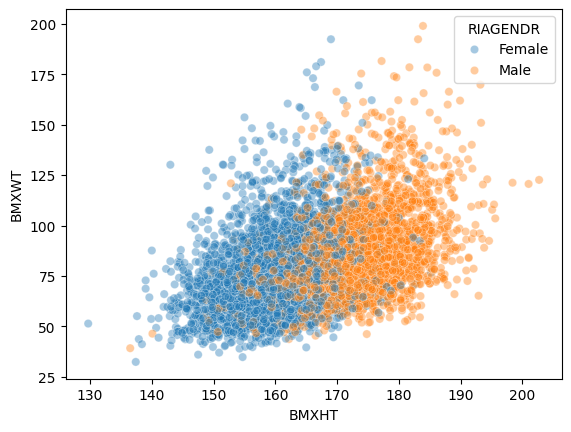

In [12]:
# YOUR CODE HERE
sb.scatterplot(x="BMXHT", y="BMXWT", hue="RIAGENDR", alpha=0.4, data=df)

<details>

```
sb.scatterplot(x="BMXHT", y="BMXWT", hue="RIAGENDR", alpha=0.4, data=df)
```

</details>

 Stratify (use `groupby` on the recorded gender variable `"RIAGENDR"`) and compute the correlation between height and weight within groups.

In [13]:
#YOUR CODE HERE
df.groupby("RIAGENDR")[["BMXHT", "BMXWT"]].corr()

/tmp/ipython-input-3442318526.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("RIAGENDR")[["BMXHT", "BMXWT"]].corr()


BMXHT     BMXWT
RIAGENDR                          
Female   BMXHT  1.000000  0.335121
         BMXWT  0.335121  1.000000
Male     BMXHT  1.000000  0.431663
         BMXWT  0.431663  1.000000

<details>

```
df.groupby("RIAGENDR")[["BMXHT", "BMXWT"]].corr()
```

</details>

Which group has higher correlation value? What does this tell us about the relationshp between these two factors for men and women?

Males have a higher correlation value which means that a change in height affects males weight increase more on average. This also means that height and weight have a stroinger positive relationship with males.

# Hypothesis Test for Correlation
#### Testing whether a correlation is “real”
So far we've computed a sample correlation between height and weight.
But is this correlation statistically significant?
Could we see a value of $r$ this large just by chance if there were really no relationship in the population?


For testing $H_0: \rho = 0$, we use a simpler approximation for the standard error of the correlation coefficient:
$$
  SE_r \approx \frac{1}{\sqrt{n}}
$$

We then form a z-test statistic:
$$
  z = \frac{r - 0}{SE_r} = r \sqrt{n}
$$

Under $H_0: \rho = 0$, this approximately follows a standard normal distribution.

Compute the z-test statistic for Pearson correlation between height and weight.

In [14]:
#YOUR CODE HERE
r = df[["BMXHT", "BMXWT"]].corr().iloc[0, 1]
n = df.shape[0]
se_r = 1 / np.sqrt(n)
z_stat = r / se_r  # equivalently: r * np.sqrt(n)
print(f"Correlation r: {r:.4f}")
print(f"Sample size n: {n}")
print(f"Standard error: {se_r:.4f}")
print(f"z-statistic: {z_stat:.3f}")

Correlation r: 0.4314
Sample size n: 5735
Standard error: 0.0132
z-statistic: 32.669


<details>

```
r = df[["BMXHT", "BMXWT"]].corr().iloc[0, 1]
n = df.shape[0]
se_r = 1 / np.sqrt(n)
z_stat = r / se_r  # equivalently: r * np.sqrt(n)
print(f"Correlation r: {r:.4f}")
print(f"Sample size n: {n}")
print(f"Standard error: {se_r:.4f}")
print(f"z-statistic: {z_stat:.3f}")
```

</details>

Assume that we are interested in testing $H_0: \rho = 0$ against $H_a: \rho \not = 0$ at $\alpha = 0.05$.
Using the z-statistic, compute the two-sided p-value using the standard normal distribution.

In [15]:
# YOUR CODE HERE
p_val = 2 * (1 - stats.norm.cdf(abs(z_stat)))
print(f"Two-sided p-value: {p_val:.5f}")

Two-sided p-value: 0.00000


<details>

```
p_val = 2 * (1 - stats.norm.cdf(abs(z_stat)))
print(f"Two-sided p-value: {p_val:.5f}")
```

</details>

Answer the following questions:
  * What is your null hypothesis $H_0$?

  * What is your alternative hypothesis $H_a$?

  * Based on the p-value, do you have enough evidence to reject $H_0$ at $\alpha = 0.05$?

The null hypothesis is basically claiming there is no linear relationship while the alternative is claiming there is a linear relationship. Based on the p value, we would have neough evidence to reject the null hypothesis.

The t-statistic above measures how far the sample correlation $r$ is from 0, scaled by how variable we expect $r$ to be if $\rho = 0$. When $H_0$ is true, most values of $t$ fall near 0. When $H_a$
is true, $t$ tends to be far from 0.

# Confidence Interval for the Correlation
A hypothesis test tells us whether the evidence suggests $\rho \not = 0$. A confidence interval gives us a range of plausible values for the population correlation $\rho$.

Using the same simple standard error approximation $SE_r = \frac{1}{\sqrt{n}}$, we can construct a $100(1- \alpha)\%$ confidence interval for $\rho$:
$$
CI = r \pm z_{\alpha/2} \times SE_{r}
$$

where $z_{\alpha/2}$ is the critical value from the standard normal distribution (e.g., 1.96 for a 95% CI).

Compute the 95% confidence interval for $r$ using the simple SE approximation.

In [17]:
# YOUR CODE HERE
alpha = 0.05
z_crit = stats.norm.ppf(1 - alpha/2)
r_lo = r - z_crit * se_r
r_hi = r + z_crit * se_r
print(f"Correlation r: {r:.4f}")
print(f"Standard error: {se_r:.4f}")
print(f"95% CI for r: [{r_lo:.3f}, {r_hi:.3f}]")

Correlation r: 0.4314
Standard error: 0.0132
95% CI for r: [0.406, 0.457]


<details>

```
# 95% confidence interval using simple SE
alpha = 0.05
se_r = 1 / np.sqrt(n)  # standard error for r
z_crit = stats.norm.ppf(1 - alpha/2)  # critical value (1.96 for 95%)

r_lo = r - z_crit * se_r
r_hi = r + z_crit * se_r

print(f"Correlation r: {r:.4f}")
print(f"Standard error: {se_r:.4f}")
print(f"95% CI for r: [{r_lo:.3f}, {r_hi:.3f}]")
```

</details>

### Interpretation:
Write a complete sentence describing this interval in context.

Example: “We are 95% confident that the true correlation between height and weight in the adult NHANES population lies between 0.48 and 0.56.”

We are 95% confident that the true correlation between height and weight in NHANES population lies between 0.406 and 0.457

* Would this interval include 0? What would that imply about the relationship?

* How would the width of this interval change if we doubled the sample size $n$?


This interval would not include 0 meaning that the relationship is linear and not due to random chance.

The width of this interval would decrease if we doubled the sample size n.

# Simple linear regression: test and confidence interval for the slope
A correlation describes how two variables move together, but it doesn't tell us how much one variable tends to change as the other changes.
A simple linear regression model expresses this relationship explicitly:
$$Y = \beta_0 + \beta_1X +ɛ$$
* $\beta_0$: intercept — expected value of $Y$ when $X=0$
* $\beta_1$: slope — expected change in $Y$ for each one-unit increase in $X$

We test $H_0: \beta_1 = 0$ vs $H_a: \beta_1 \not = 0$ using a t-statistic from the regression output.

Fit a simple linear regression predicting weight (BMXWT) from height (BMXHT) using `sm.OLS`, and display the model summary.

In [18]:
#YOUR CODE HERE

X = sm.add_constant(df["BMXHT"])
y = df["BMXWT"]
model = sm.OLS(y, X, missing='drop').fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  BMXWT   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     1294.
Date:                Tue, 04 Nov 2025   Prob (F-statistic):          2.07e-255
Time:                        15:37:17   Log-Likelihood:                -24891.
No. Observations:                5662   AIC:                         4.979e+04
Df Residuals:                    5660   BIC:                         4.980e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -73.4747      4.311    -17.042      0.0

<details>

```
# Fit regression model: Weight ~ Height
X = sm.add_constant(df["BMXHT"])   # adds intercept term
y = df["BMXWT"]
model = sm.OLS(y, X, missing='drop').fit()

# Display the model summary
print(model.summary())
```

</details>

From the summary output above, you can see the slope estimate, standard error, t-value, p-value, and confidence interval. You can also extract these values programmatically as shown below.

In [19]:
#YOUR CODE HERE
beta0, beta1 = model.params
se_beta1 = model.bse["BMXHT"]
t_beta1 = model.tvalues["BMXHT"]
p_beta1 = model.pvalues["BMXHT"]
ci_beta1 = model.conf_int().loc["BMXHT"]

print(f"Slope (beta1): {beta1:.4f}")
print(f"SE(beta1): {se_beta1:.4f}")
print(f"t({int(model.df_resid)}): {t_beta1:.3f}")
print(f"p-value: {p_beta1:.5f}")
print(f"95% CI for beta1: [{ci_beta1[0]:.3f}, {ci_beta1[1]:.3f}]")

Slope (beta1): 0.9318
SE(beta1): 0.0259
t(5660): 35.974
p-value: 0.00000
95% CI for beta1: [0.881, 0.983]


<details>

```
# Extract key results
beta0, beta1 = model.params
se_beta1 = model.bse["BMXHT"]
t_beta1 = model.tvalues["BMXHT"]
p_beta1 = model.pvalues["BMXHT"]
ci_beta1 = model.conf_int().loc["BMXHT"]

print(f"Slope (beta1): {beta1:.4f}")
print(f"SE(beta1): {se_beta1:.4f}")
print(f"t({int(model.df_resid)}): {t_beta1:.3f}")
print(f"p-value: {p_beta1:.5f}")
print(f"95% CI for beta1: [{ci_beta1[0]:.3f}, {ci_beta1[1]:.3f}]")

```

</details>

Compare to your earlier test for $r=0$.

The iverall r value seems to have increased by a lot.

### Interpretation:
* What does the slope estimate mean in the context of these variables?

Example: “For each additional centimeter of height, weight increases by about ___ kilograms on average.”

* Does the 95% CI include 0?
* How does this test's conclusion compare to the correlation test?

For each additional centimeter of height, weight increases by about 0.948 kilograms on average. The 95% confidence interval does not include 0. They have the same conclusion that there is a correlation between these 2 variables by rejecting the null hypothesis.

### Visualizing the regression line
Let us  plot regression line on top of the scatterplot to visualize the estimated relationship.

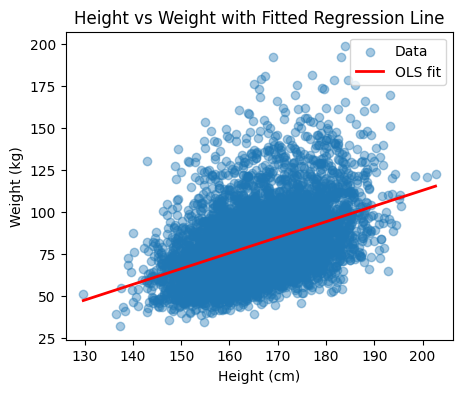

In [20]:
# Plot data and fitted line
plt.figure(figsize=(5,4))
plt.scatter(df["BMXHT"], df["BMXWT"], alpha=0.4, label="Data")
xg = np.linspace(df["BMXHT"].min(), df["BMXHT"].max(), 200)
yg = beta0 + beta1 * xg
plt.plot(xg, yg, color="red", linewidth=2, label="OLS fit")
plt.xlabel("Height (cm)")
plt.ylabel("Weight (kg)")
plt.title("Height vs Weight with Fitted Regression Line")
plt.legend()
plt.show()

* Is the direction of the slope (positive/negative) consistent with the sign of $r$?
Yes
* What is the relationship between $\beta_1$ and $r$?
(Hint: in simple linear regression, $\hat{\beta_1} = r \cdot S_Y/ S_X$.)
They are proportional. SO an increase in one leads to an increase in another.

# Equivalence of the Correlation Test and the Slope Test

In simple linear regression, the slope estimate $\hat{\beta_1}$ and the correlation $r$ are directly related:
$$\hat{\beta_1} = r\frac{S_Y}{S_X}$$
where $S_X$ and $S_Y$ are the sample standard deviations of $X$ and $Y$.

Because of this relationship, the hypothesis tests
$H_0: \rho = 0$ and $H_0: \beta_1 = 0$ are closely related. We used a z-test for correlation (with the simpler SE approximation) and the OLS output shows a t-test for the slope. With large sample sizes like we have here, these two tests will give very similar results and lead to the same conclusion.

**Note:** The exact relationship is that both tests have the same degrees of freedom ($n-2$) and will give identical results when using the exact t-test for both. For simplicity in this lab, we used the approximate z-test for correlation, which works well with large samples.

Compute the slope predicted by this formula using your earlier correlation.

In [21]:
#YOUR CODE HERE
sx = df["BMXHT"].std(ddof=1)
sy = df["BMXWT"].std(ddof=1)

beta1_from_r = r * (sy / sx)

print(beta1_from_r)

0.9315024921523447


<details>

```
# compute sample sd for X and Y
sx = df["BMXHT"].std(ddof=1)
sy = df["BMXWT"].std(ddof=1)

# compute slope predicted by correlation
beta1_from_r = r * (sy / sx)

print(beta1_from_r)
```

</details>

Compare it to the slope estimated by your regression model.

They are the same.

Compare both p-values from the correlation z-test and the OLS t-test for the slope.

They are similar.

### Interpretation:
Explain in words why these two tests produce similar results (the p-values should be very close).
What does this tell us about the relationship between correlation and regression in the simple (one predictor) case?
With our large sample size, why do the z-test (for correlation) and t-test (for slope) give such similar answers?

They provide similar results due to a large sample size. They both measure relationship between variables but regression measures how one variable affects the other while correlation measures the strength and direction of overall relationship. A larger sample size would lead to more precise results in both z and t test. This is because the correlation is the slope.